<a href="https://colab.research.google.com/github/takaito1/EAS2655_S25/blob/main/EOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 31.5 MB/s eta 0:00:00


#EOF analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from google.colab import drive
from cartopy import crs as ccrs
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
# Open a NetCDF dataset using xarray
ds = xr.open_dataset('/content/drive/MyDrive/Colab Notebooks/air.mon.mean.nc')

# Display dataset metadata and contents
ds


<xarray.Dataset> Size: 39MB
Dimensions:  (lat: 73, lon: 144, time: 925)
Coordinates:
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2025-01-01
Data variables:
    air      (time, lat, lon) float32 39MB ...
Attributes:
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/...
    title:          monthly mean air.sig995 from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [75]:
# Select and convert longitude values within the range [120, 280] degrees to a NumPy array
x = ds.lon.sel(lon=slice(120, 280)).to_numpy()

# Select and convert latitude values within the range [20, -20] degrees to a NumPy array
# This is a region around the equator
y = ds.lat.sel(lat=slice(20, -20)).to_numpy()

# Extract the time variable from the dataset
time = ds.time

# Select air temperature data within the specified longitude and latitude range
air = ds.air.sel(lon=slice(120, 280), lat=slice(20, -20))


In [76]:
# Compute the climatological monthly mean of air temperature
# Group the data by month and take the mean across all years
air_clim = air.groupby('time.month').mean('time')


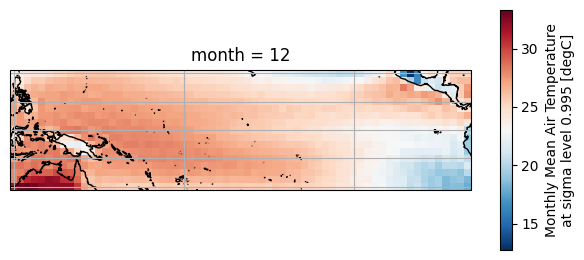

In [77]:
# Create a figure with a specified size for the plot
fig = plt.figure(figsize=(7.2, 3))

# Add axes to the figure with a PlateCarree projection (for global maps) centered around 150° longitude
ax = fig.add_axes([.1, .1, .8, .8], projection=ccrs.PlateCarree(central_longitude=150))

# Plot the climatological air temperature for December (month=12) using the specified colormap (RdBu_r)
# Apply the PlateCarree projection to the data
air_clim.sel(month=12).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r')

# Add coastlines to the plot for better geographical reference
ax.coastlines()

# Add gridlines to the plot for easier visual reference of latitude and longitude
ax.gridlines()



In [78]:
# Compute the monthly air temperature anomalies by subtracting the climatological monthly mean (air_clim) from the original data (air)
air_anom = air.groupby('time.month') - air_clim


In [79]:
# Function to transform latitude-longitude data into a new coordinate system (X)
def latlon2X(data, lat):
    # Get the dimensions of the input data: Nt (time), Ny (latitude), Nx (longitude)
    Nt, Ny, Nx = np.shape(data)

    # Initialize an empty array to hold the transformed data (reshaped into Nx*Ny rows and Nt columns)
    D = np.zeros((Nx * Ny, Nt))

    # Precompute the cosine of the latitude values to scale the data (used for area weighting)
    rtcoslat = np.sqrt(np.cos(np.deg2rad(lat)))

    # Loop over latitude and longitude to fill the transformed data matrix
    for j in range(Ny):  # Loop over latitudes
        for i in range(Nx):  # Loop over longitudes
            # Scale the data by the square root of the cosine of latitude and store it in the transformed matrix
            D[i + j * Nx, :] = data[:, j, i] * rtcoslat[j]

    # Return the transformed data
    return D


In [80]:
# Function to detrend a 3D dataset (time, latitude, longitude)
def detrend2D(data):
    # Get the dimensions of the input data: Nt (time), Ny (latitude), Nx (longitude)
    Nt, Ny, Nx = np.shape(data)

    # Create an array of time indices for detrending
    t = np.arange(0, Nt, 1)

    # Initialize an array to store the detrended data
    datadt = np.zeros((Nt, Ny, Nx))

    # Loop over all longitude and latitude points to detrend the time series for each
    for i in range(Nx):  # Loop over longitudes
        for j in range(Ny):  # Loop over latitudes
            # Compute the covariance between time and the data for this (j, i) location
            c = np.cov(t, data[:, j, i])

            # Remove the linear trend by subtracting the fitted trend (using the covariance)
            datadt[:, j, i] = data[:, j, i] - t * c[0, 1] / c[0, 0]

    # Return the detrended data
    return datadt


In [109]:
# Detrend the air temperature anomalies (air_anom) using the detrend2D function
D0 = detrend2D(air_anom)

# Transform the detrended data (D0) from latitude-longitude to a new coordinate system (X)
# using the latlon2X function, with latitude values (y)
D = latlon2X(D0, y)

# Check and display the shape of the detrended data (D0) to confirm the transformation
np.shape(D0)


(925, 17, 65)

In [110]:
# Get the number of time steps (Nt) by determining the size of the time array
N = np.size(time)

# Compute the covariance matrix (C) of the transformed data (D)
# The matrix D is multiplied by its transpose and normalized by (N-1)
C = 1 / (N - 1) * D @ D.T

# Check and display the shape of the covariance matrix (C)
np.shape(C)

(1105, 1105)

In [111]:
# Compute the eigenvalues (L) and eigenvectors (E) of the covariance matrix (C)
# L will contain the eigenvalues, and E will contain the corresponding eigenvectors
L, E = np.linalg.eig(C)

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


Text(0, 0.5, 'Fraction of variance')

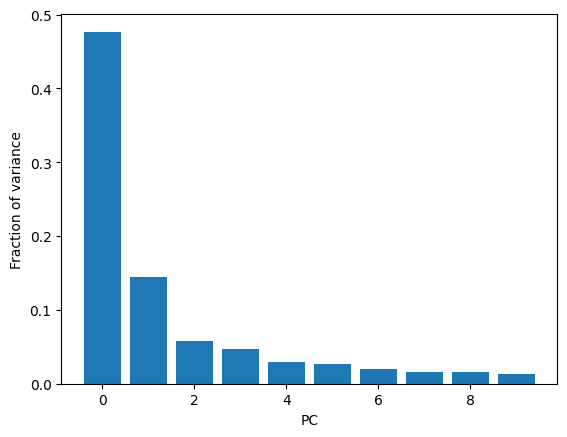

In [112]:
# Compute the fraction of variance explained by each principal component (PC)
# ev represents the fraction of variance explained by each eigenvalue (L)
ev = L / np.sum(L)

# Create a bar plot of the first 10 principal components (PCs) and their explained variance
plt.bar(np.arange(0, 10, 1), ev[:10])

# Label the x-axis as the index of the principal components
plt.xlabel('PC')

# Label the y-axis as the fraction of variance explained by each principal component
plt.ylabel('Fraction of variance')


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'PC1')

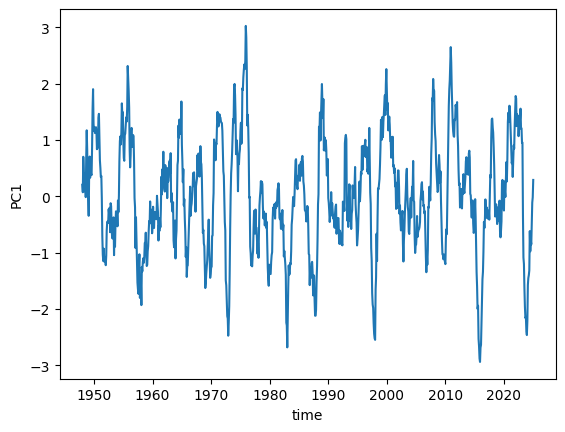

In [113]:
# Compute the first principal component (PC1) by projecting the data onto the first eigenvector (E[:,0])
PC1 = E[:, 0] @ D

# Z-transform PC1 by subtracting its mean and dividing by its standard deviation
# This standardizes the principal component, making it have a mean of 0 and standard deviation of 1
PC1 = (PC1 - np.mean(PC1)) / np.std(PC1)
#
# plot PC1 as a function of time
plt.plot(time,PC1)
plt.xlabel('time')
plt.ylabel('PC1')

In [118]:
# Function to perform 2D regression between the data and a principal component (PC)
def regr2D(data, PC):
    # Get the dimensions of the input data: Nt (time), Ny (latitude), Nx (longitude)
    Nt, Ny, Nx = np.shape(data)

    # Initialize an array to store the regression coefficients
    regr = np.zeros((Ny, Nx))

    # Loop over all latitude and longitude points to compute the regression for each
    for j in range(Ny):  # Loop over latitudes
        for i in range(Nx):  # Loop over longitudes
            # Compute the covariance between the principal component (PC) and the data for this (j, i) location
            c = np.cov(PC, data[:, j, i])

            # Calculate the regression coefficient (slope) for the current grid point
            # This is the ratio of the covariance between PC and data to the vari
            regr[j, i] = c[0, 1] / c[0, 0]

    # Return the regression coefficients
    return regr

In [120]:
# Perform the 2D regression between the detrended data (D0) and the first principal component (PC1)
# The function regr2D computes the regression coefficient (slope) at each grid point
#
# This determines the EOF1 as regression coefficient with physical units (deg C per SD)
EOF1 = regr2D(D0, PC1)


<ipython-input-118-3b8976bd997d>:17: ComplexWarning: Casting complex values to real discards the imaginary part
  regr[j, i] = c[0, 1] / c[0, 0]


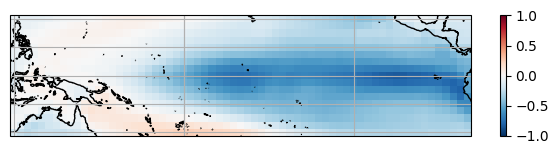

In [121]:
# Create a figure with a specified size for the plot
fig = plt.figure(figsize=(7.2, 3))

# Add axes to the figure with a PlateCarree projection (for global maps) centered around 150° longitude
ax = fig.add_axes([.1, .1, .8, .8], projection=ccrs.PlateCarree(central_longitude=150))

# Create a color mesh plot to visualize the EOF1 (empirical orthogonal function) on the map
# The x and y arrays represent the longitude and latitude grid, and EOF1 is the data to be plotted
# Transform the data to the PlateCarree projection and set the color limits (vmin, vmax)
im = ax.pcolormesh(x, y, EOF1, transform=ccrs.PlateCarree(),vmin=-1, vmax=1, cmap='RdBu_r')

# Add coastlines to the plot for better geographical reference
ax.coastlines()

# Add gridlines to the plot for easier visual reference of latitude and longitude
ax.gridlines()

# Add a colorbar to the plot, placed on the right side, and shrink it by 50% for better fitting
plt.colorbar(im, ax=ax, location='right', shrink=.5)
